# Quickstart
The following notebook introduces `iconspy`'s datatypes and some of their associated methods.

Having followed through this tutorial you will be able to construct and visusalise `iconspy` sections.

In [145]:
from pathlib import Path
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import iconspy as ispy
import cmocean.cm as cmo

## Load and prepare the example data

We will load from netcdf files as `tgrid` which describes the model grid, and an `fxgrid` which contains bathymetry information.

We then have to put them in a format that `iconspy` can understand. For the `tgrid` this means calling `ispy.convert_tgrid_data`, and for the the `fxgrid` we must make sure the dimensions have the correct names.

In [2]:
shared_data_path = Path("/pool/data/ICON/oes/input/r0006/")
R02B04_path = shared_data_path / "icon_grid_0036_R02B04_O"
grid_path = R02B04_path / "R2B4_ocean-grid.nc"
fx_path = R02B04_path / "R2B4L40_fx.nc"

ds_tgrid = xr.open_dataset(grid_path)  # horizontal grid information
ds_fx = xr.open_dataset(fx_path)  # Contains bathymetry etc.

# Put datasets into the iconspy format
ds_IsD = ispy.convert_tgrid_data(ds_tgrid)

ds_fx = ds_fx.rename(
    {
        "ncells": "cell",
        "ncells_2": "edge",
        "ncells_3": "vertex",
    }
)



/work/mh0256/m301014/iconspy/iconspy/utils.py:205: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  ds_IcD[point] = np.arange(ds_IcD.dims[point], dtype="int32")


## Define the stations we want to connect
To define a section we need two or more points to connect. Typically we have a rough idea of where we want these points to be, and we would like to choose the model grid points closest to these coordinates. Sometimes we have a desire for one of the points to be on land.

In the below we will define a section near Fram Strait, stretching from a point on Greenland to a point offshore.

In [155]:
def setup_plot_area(ds_IsD):
    Slat, Nlat = 0, 20
    Wlon, Elon = -60, -20

    edges_in_region = ds_IsD["edge"].where(
        (ds_IsD["elon"] > Wlon) * (ds_IsD["elon"] < Elon) * (ds_IsD["elat"] > Slat) * (ds_IsD["elat"] < Nlat)
        , drop=True).astype("int32")


    lons = ds_IsD["vlon"].sel(vertex=ds_IsD["edge_vertices"])
    lats = ds_IsD["vlat"].sel(vertex=ds_IsD["edge_vertices"])

    fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})

    for edge in edges_in_region:
        ax.plot(
            lons.isel(edge=edge),
            lats.isel(edge=edge),
            color="black",
            alpha=0.2,
        )

    ax.scatter(
        ds_IsD["vlon"],
        ds_IsD["vlat"],
        s=4,
        transform=ccrs.PlateCarree(),
        color="tab:green"
    )

    ax.set_xlim(Wlon, Elon)
    ax.set_ylim(Slat, Nlat)
    ax.set_aspect("equal")

    ax.coastlines()
    # ax.gridlines()
    return fig, ax

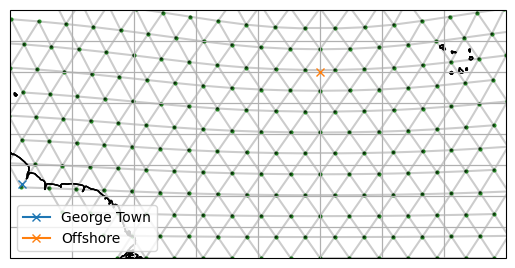

In [152]:
# Put in the approximate coordinates of the points we want
# Specify that we want the George Town point to be on the boundary
target_GeorgeTown = ispy.TargetStation("George Town", -59, 6, boundary=True)
target_offshore = ispy.TargetStation("Offshore", -35, 15, boundary=False)

# Visualise the points
fig, ax = setup_plot_area(ds_IsD)
target_GeorgeTown.plot(ax=ax)
target_offshore.plot(ax=ax)
ax.legend()

The map shows the approximate location of the points we want to join. We can now find the model grid points nearest to them and plot them.

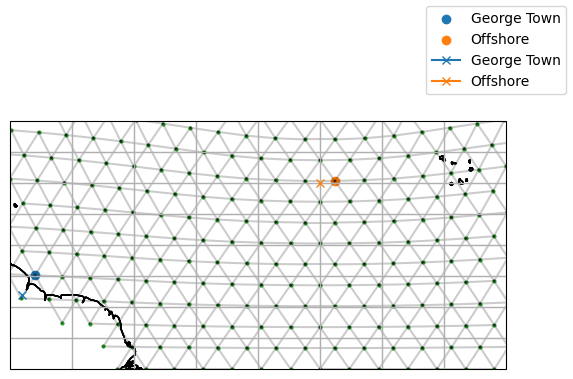

In [153]:
# Convert the target stations to model stations
model_GeorgeTown = target_GeorgeTown.to_model_station(ds_IsD)
model_offshore = target_offshore.to_model_station(ds_IsD)

fig, ax = setup_plot_area(ds_IsD)

# Plot the model stations (circles)
model_GeorgeTown.plot(ax=ax)
model_offshore.plot(ax=ax)

# Compare with the target station (crosses)
target_GeorgeTown.plot(ax=ax)
target_offshore.plot(ax=ax)

fig.legend()

## Connect stations to form a section

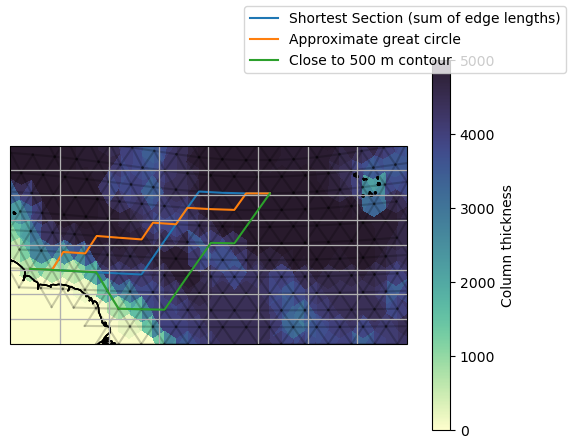

In [164]:
shortest = ispy.Section(
    "Shortest Section (sum of edge lengths)",
    model_GeorgeTown,
    model_offshore,
    ds_IsD,
    section_type="shortest"
)

great_circle = ispy.Section(
    "Approximate great circle",
    model_GeorgeTown,
    model_offshore,
    ds_IsD,
    section_type="great circle"
)

contour = ispy.Section(
    "Close to 500 m contour",
    model_GeorgeTown,
    model_offshore,
    ds_IsD,
    section_type="contour",
    contour_data=ds_fx["column_thick_e"],
    contour_target=500,
)

fig, ax = setup_plot_area(ds_IsD)
shortest.plot(ax=ax)
great_circle.plot(ax=ax)
contour.plot(ax=ax)

fig.legend()

cax = ax.tripcolor(
    ds_IsD["clon"],
    ds_IsD["clat"],
    ds_fx["column_thick_c"],
    vmin=0,
    vmax=5000,
    cmap=cmo.deep,
)

fig.colorbar(cax, ax=ax, label="Column thickness")